<a href="https://colab.research.google.com/github/RiceWater/Sidewalk-Verification-Testing/blob/main/Sidewalk_Verification_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE:
This model classifies images to two things:
1. Good/clean road (Value is 1)
2. Road with issue (Value is 0)

Data augmentation is applied, such as tf.RandomFlip() and tf.RandomRotation()

### Things To Note:
1. Apparently, you need a lot of epochs for this model (Or NNs in general I suppose)
2. Adam's default learning rate is [0.001](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

Also, this uses the Road_DatasetsV1 folder in my GDRive

### To do in next iteration:
1. Check if you can visually see the trained model
2. Check if you can see the final weights and biases for each node/layer
3. Check how to load things from Firebase

# 1

## Install Dependencies

In [ ]:
import tensorflow as tf
import os

## Remove Faulty Images

In [ ]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Road_DatasetsV1/Sidewalks'

In [ ]:
# os.listdir(os.path.join(data_dir, 'Broken_Sidewalks'))

In [ ]:
file_count_broken, file_count_clean = len(os.listdir(os.path.join(data_dir, 'Broken_Sidewalks'))), len(os.listdir(os.path.join(data_dir, 'Clean_Sidewalks')))
print(file_count_broken, file_count_clean)

97 115


In [ ]:
image_test = cv2.imread(os.path.join(data_dir, 'Broken_Sidewalks', 'tree_sidewalk-1.jpg'))
image_test.shape
plt.imshow(image_test)
plt.imshow(cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
for image_class in os.listdir(data_dir):  # For each folder in this path
  for file_item in os.listdir(os.path.join(data_dir, image_class)): # For each item in the folder
    image_path = os.path.join(data_dir, image_class, file_item)  # Get the path of the item
    try:
      img = cv2.imread(image_path)
      ext = imghdr.what(image_path)
      if ext not in image_exts:
        print('Removing {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Error reading {}'.format(image_path))
      os.remove(image_path)



In [ ]:
new_file_count_broken, new_file_count_clean = len(os.listdir(os.path.join(data_dir, 'Broken_Sidewalks'))), len(os.listdir(os.path.join(data_dir, 'Clean_Sidewalks')))
print(new_file_count_broken, new_file_count_clean)

97 115


## Load Data

In [ ]:
# tf.data.Dataset?? #'??' is for checking documentaiton

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# tf.keras.utils.image_dataset_from_directory??

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 212 files belonging to 2 classes.


In [ ]:
data_iter = data.as_numpy_iterator()

In [ ]:
batch = data_iter.next()

In [ ]:
len(batch) # length is 2 (first is image; second is class/label)

2

In [ ]:
batch[1][0]
# plt.subplots??

0

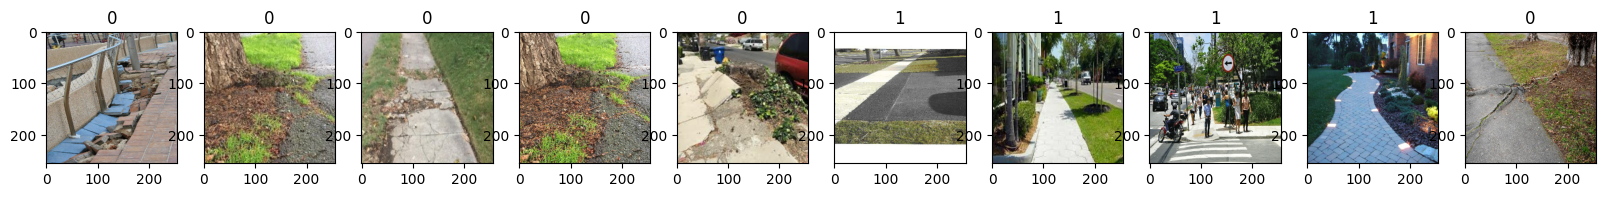

In [ ]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, picture in enumerate(batch[0][:10]):
  ax[idx].imshow(picture.astype(int))
  ax[idx].title.set_text(batch[1][idx])

# 0 = broken sidewalk; 1 = clean sidewalk

# 2

## Scale Data

In [ ]:
scaled_data = data.map(lambda x, y: (x / 255, y)) # Making values within 0-1 and not 0-255
scaled_data

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
scaled_data_iter = scaled_data.as_numpy_iterator()

In [ ]:
scaled_batch = scaled_data_iter.next()

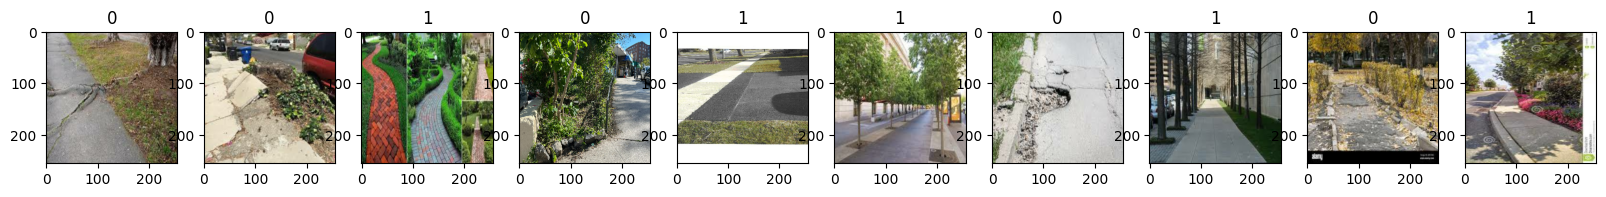

In [ ]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, picture in enumerate(scaled_batch[0][:10]):
  ax[idx].imshow(picture)
  ax[idx].title.set_text(scaled_batch[1][idx])
  # 1 - clean side walk

## Split Data

In [ ]:
train_size = int(len(scaled_data) * 0.6)
test_size = int(len(scaled_data) * 0.2) + 1
val_size = int(len(scaled_data) * 0.2) + 1
print(train_size, test_size, val_size)

4 2 2


In [ ]:
train = scaled_data.take(train_size)
test = scaled_data.skip(train_size).take(test_size)
val = scaled_data.take(train_size + test_size).take(val_size)

## Applying Data Augmentation on Training Data

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation

In [ ]:
data_aug_model = Sequential()
data_aug_model.add(RandomFlip(mode='vertical', input_shape=(256, 256, 3), seed=1))
data_aug_model.add(RandomRotation(factor=0.3, seed=1))

# 3

## Applying Data Augmentation (OLD)

In [ ]:
# import albumentations as A
# import random

In [ ]:
# transform = A.Compose([
#     A.CLAHE(),
#     A.RandomRotate90(),
#     A.Transpose(),
#     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
#     A.Blur(blur_limit=3),
#     A.OpticalDistortion(),
#     A.GridDistortion(),
#     A.HueSaturationValue(),
# ])
# random.seed(1)

In [ ]:
# transform = A.Compose([
#     A.Resize(256,256),
#     A.CLAHE(),
#     A.Blur(blur_limit=(3,13), p=.5),
#     A.Rotate(limit=(-90,90)),
#     A.HorizontalFlip(p=.4),
#     A.VerticalFlip(p=.4),
# ])
# random.seed(1)

In [ ]:
# def augment_func(image):
#   transformed = transform(image=image)['image']
#   # transformed = tf.cast(transformed/255, tf.float32)
#   return transformed

# def process_data(image, label, augment_func=augment_func):
#   transformed_image = tf.numpy_function(augment_func, inp=[image], Tout=tf.float32)
#   return transformed_image, label

In [ ]:
# s_data_testing = tf.identity(scaled_data)

# s = s_data_testing.map(process_data)
# s

In [ ]:
# s_iter = s.as_numpy_iterator()

In [ ]:
# b = s_iter.next()

In [ ]:
# batch[0][0]

## Build

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
model = Sequential()
model.add(data_aug_model)
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
# tf.keras.metrics??

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)       

## Train

In [ ]:
logdir = '/content/drive/MyDrive/Colab Notebooks/Road_DatasetsV1'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=65, validation_data=val, callbacks=[tensorboard_callback])

## Check Performance

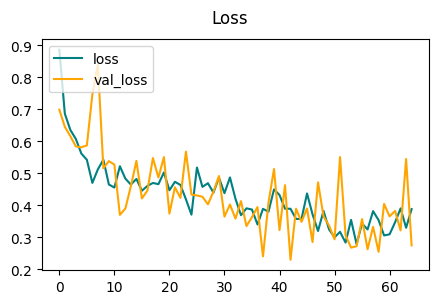

In [ ]:
fig = plt.figure(figsize=(5,3))
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.suptitle('Loss')
plt.legend(loc='upper left')
plt.show()

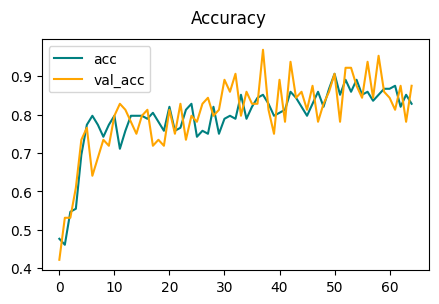

In [ ]:
fig = plt.figure(figsize=(5,3))
plt.plot(hist.history['accuracy'], color='teal', label='acc')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
plt.suptitle('Accuracy')
plt.legend(loc='upper left')
plt.show()

# 4

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre, rec, accur = Precision(), Recall(), BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X,y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  rec.update_state(y, yhat)
  accur.update_state(y, yhat)

1/1 [==============================] - 0s 442ms/step


In [ ]:
type(pre.result().numpy())

numpy.float32

In [ ]:
print(
"""Precision: {}
Recall: {}
Accuracy: {}
F1-Score: {}"""
.format(
    np.round(pre.result().numpy() * 100, 2),
    np.round(rec.result().numpy() * 100, 2),
    np.round(accur.result().numpy() * 100, 2),
    np.round(100 * (2 * pre.result().numpy() * rec.result().numpy()) / (pre.result().numpy()
    + rec.result().numpy()), 2)
    )
)

Precision: 87.5
Recall: 87.5
Accuracy: 87.5
F1-Score: 87.5


## Test with new data

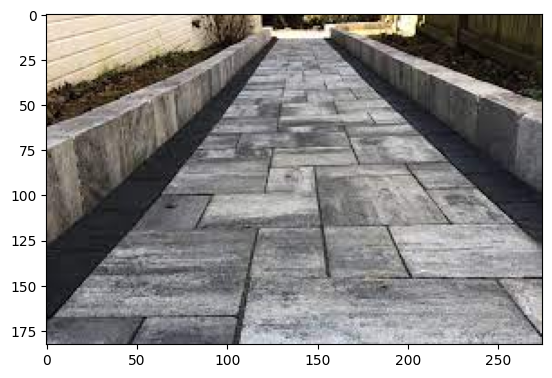

In [ ]:
cln_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Road_DatasetsV1/unseen sidewalks/1.jpg')
plt.imshow(cv2.cvtColor(cln_img, cv2.COLOR_BGR2RGB))

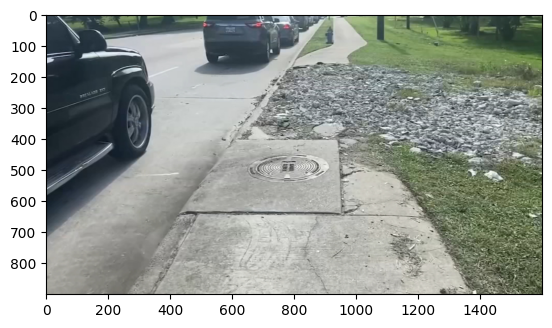

In [ ]:
b_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Road_DatasetsV1/unseen sidewalks/b.jpg')
plt.imshow(cv2.cvtColor(b_img, cv2.COLOR_BGR2RGB))

In [ ]:
c_resize = tf.image.resize(cln_img, (256,256))
b_resize = tf.image.resize(b_img, (256,256))

In [ ]:
# Threshold is 0.55; 0 - broken sidewalk, 1 - clean sidewalk
def classify(y):
  threshold = 0.55
  if y < threshold:
    print('The sidewalk has issue. Thank you for your report.')
  else:
    print('The sidewalk has no issue. Kindly reangle if you believe there is an issue.')

In [ ]:
yhat2 = model.predict(np.expand_dims(b_resize/255, 0))
classify(yhat2[0][0])
print(yhat2[0][0])

1/1 [==============================] - 0s 235ms/step
The sidewalk has issue. Thank you for your report.
0.08045449


In [ ]:
c2_path = '/content/drive/MyDrive/Colab Notebooks/Road_DatasetsV1/unseen sidewalks/c2.jpg'
c2_img = cv2.imread(c2_path)


In [ ]:
img = cv2.imread(c2_path)
ext = imghdr.what(c2_path)
if ext not in image_exts:
  print('Removing {}'.format(c2_path))
  os.remove(c2_path)

  # print('Error reading {}'.format(b2_path))
  # os.remove(b2_path)

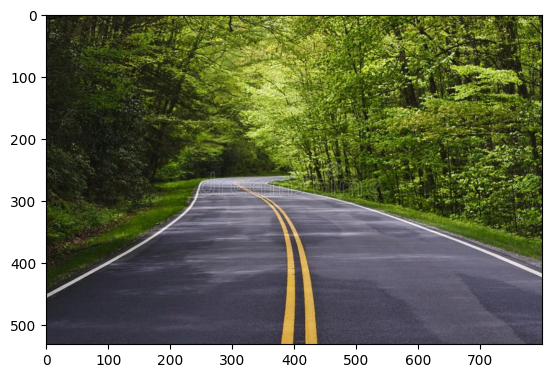

In [ ]:
plt.imshow(cv2.cvtColor(c2_img, cv2.COLOR_BGR2RGB))

In [ ]:
c2_resize = tf.image.resize(c2_img, (256,256))

In [ ]:
yhat3 = model.predict(np.expand_dims(c2_resize/255, 0))
classify(yhat3[0][0])
print(yhat3[0][0])

1/1 [==============================] - 0s 60ms/step
The sidewalk has no issue. Kindly reangle if you believe there is an issue.
0.9011125
